In [64]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import math

In [65]:
# Get data for a given ticker
ticker = "AMZN"
data = yf.Ticker(ticker).history("10y")
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-12-24 00:00:00-05:00,12.8650,12.9750,12.8480,12.9310,19688000,0.0,0.0
2012-12-26 00:00:00-05:00,12.8575,12.8710,12.4020,12.4315,83054000,0.0,0.0
2012-12-27 00:00:00-05:00,12.4140,12.4675,12.1430,12.4155,72786000,0.0,0.0
2012-12-28 00:00:00-05:00,12.2925,12.3720,12.2525,12.2590,37174000,0.0,0.0
2012-12-31 00:00:00-05:00,12.1875,12.6205,12.1375,12.5435,68380000,0.0,0.0


In [66]:
# calculate shot and long term moving average 
short_day = 20
long_day = 200
data["SMA"] = data["Open"].rolling(window = short_day).mean()
data["LMA"] = data["Open"].rolling(window = long_day).mean()

Let's first visualise the data with a plot of the price and moving averages.

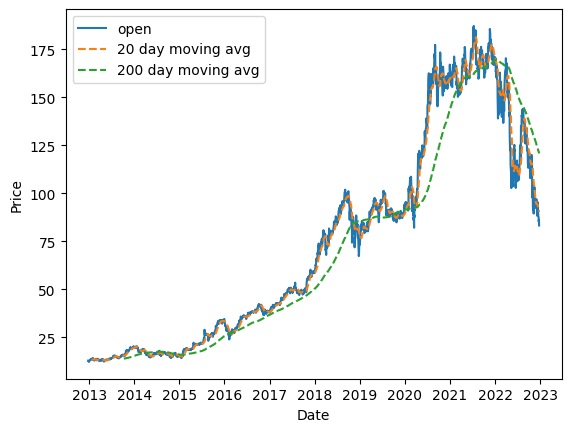

In [67]:
plt.plot(data["Open"], label = "open")
plt.plot(data["SMA"], ls = '--', label = "{} day moving avg".format(short_day))
plt.plot(data["LMA"], ls = '--', label = "{} day moving avg".format(long_day))
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# Simple Moving Average Crossover
We execture a simple moving average crossover strategy.  
When the SMA moves above the LMA and we aren't holding a stock we buy as much as possible.  
When the LMA moves above the SMA and we are holding a stock we sell as much as possible.  
If there is no crossover we continue doing as usual.  
  
We have accounted for the transaction fee as a percentage.  
  
We include a risk allowance - if the stock price falls more than x% away from the price we made the last buy at, then we exit the trade to avoid losing too much money.
  
We will also calculate the risk free rate and return on buying and holding as benchmarks.  

In [68]:
# initialise position and capital
starting_capital = 1000
data["Capital"] = starting_capital
data["Profit"] = 0
data["risk_free_return"] = starting_capital
data["shares_held"] = 0
data["buy_and_hold_capital"] = 0

In [69]:
prev_row = data.iloc[0] # save the first row

# purchase all posible stock for buy and hold strategy
first_time = data.index[0]
buy_and_hold_stock_number = math.floor(prev_row["Capital"]/prev_row["Close"])
data["buy_and_hold_capital"] = starting_capital - buy_and_hold_stock_number * prev_row["Close"]
data.loc[first_time, "buy_and_hold_capital"] = starting_capital

In [70]:
trading_fee = 0.005 # trading fee as a percentage
risk_free_rate = 0.05
allowed_risk = 0.05 # if price falls too much below buy price we sell to cover loss

# loop over days from the second row
for t, row in data.iloc[1:].iterrows():

    # calculate risk free return on capital
    data.loc[t, "risk_free_return"] = prev_row["risk_free_return"] * (1+risk_free_rate/365)

    # if short term average goes above the long term average and we arent holding a stock
    # buy all shares
    if(row["SMA"] > row["LMA"] and prev_row["shares_held"] == 0):
        capital_yesturday = prev_row['Capital']
        data.loc[t, "shares_held"] = math.floor(capital_yesturday/row['Close']) 
        data.loc[t, "Capital"] = capital_yesturday - data.loc[t, "shares_held"] * row['Close'] * (1 + trading_fee)
        buy_price = row['Close'] * (1 + trading_fee)

    # if long term average goes above the short term average, or the trade becomes to risk, and we are holding stock
    # sell all shares
    elif(row["LMA"] > row["SMA"] and prev_row["shares_held"] != 0 or 
    (prev_row["shares_held"] != 0 and prev_row["Close"] < (1 - allowed_risk)*buy_price)):
        capital_yesturday = prev_row['Capital']
        data.loc[t, "Capital"] = capital_yesturday + prev_row["shares_held"] * row['Close'] * (1 - trading_fee)
        sell_price = row['Close'] * (1 - trading_fee)
        data.loc[t, "Profit"] = (sell_price - buy_price) * prev_row["shares_held"]
        data.loc[t, "shares_held"] = 0

    # no crossover so do nothing
    else:
        data.loc[t, "Capital"] = prev_row["Capital"]
        data.loc[t, "shares_held"] = prev_row["shares_held"]

    prev_row = data.loc[t]

In [71]:
# calculate capital from holding stock all this time = number of stocks we bought * final price
data.loc[t, "buy_and_hold_capital"] = buy_and_hold_stock_number * prev_row["Close"]

# calculate buy and hold profit = cummulative sum of price changes * number of stocks we bought to begin with
data["buy_and_hold_profit"] = (data["Close"] - data["Close"].iloc[0]) * buy_and_hold_stock_number

# find the cummulative profit
data["cum_profit"] = data["Profit"].cumsum()

# find risk free profit = return - starting capital
data["risk_free_profit"] = data["risk_free_return"] - starting_capital

Lets plot the results of this strategy.

<AxesSubplot: xlabel='Date', ylabel='Profit'>

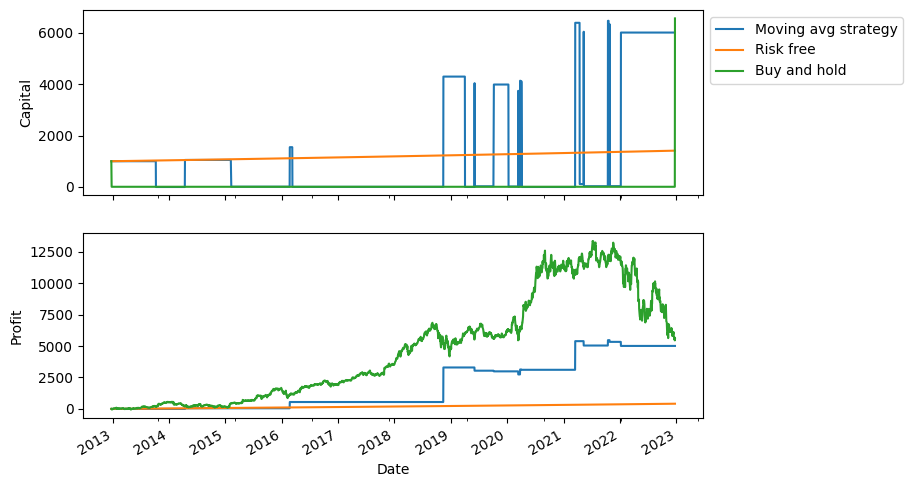

In [72]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# capital subplot
ax1.set_ylabel("Capital")
data.plot(y = "Capital", ax=ax1, label = "Moving avg strategy")
data.plot(y = "risk_free_return", ax = ax1, label = "Risk free")
data.plot(y = "buy_and_hold_capital", ax = ax1, label = "Buy and hold")
ax1.legend(loc="upper left", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

# profit subplot
ax2.set_ylabel("Profit")
data.plot(y = "cum_profit", ax=ax2, legend = False)
data.plot(y = "risk_free_profit", ax = ax2, legend = False)
data.plot(y = "buy_and_hold_profit", ax = ax2, legend = False)

The results are fairly poor. The strategy tends to beat out a risk free bond investment but is not better than simply buying and holding the stock in most cases.

## Short-selling

To improve the results we can try to make use of short selling to make money on the downturns. 